In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from lightning_module import MNISTAutoencoder, MNISTVAE

In [4]:
#CKPT_PATH = "/home/konrad/fun/VAE/logs/fc_lat_dim_20/version_1/checkpoints/epoch=29-step=8219.ckpt"
CKPT_PATH = "/home/konrad/fun/VAE/logs/fewer_params_alpha_0.008_VAE_lat_dim_20_lr_0.001/version_0/checkpoints/epoch=96-step=26577.ckpt"


In [5]:
#model = MNISTAutoencoder.load_from_checkpoint(CKPT_PATH)
model = MNISTVAE.load_from_checkpoint(CKPT_PATH)

In [6]:
encoder = model.model.encoder
decoder = model.model.decoder

In [7]:
# find the latent space

loader = model.train_dataloader()

In [8]:
batch_imgs, batch_lbls = next(iter(loader))

In [ ]:
#for autoencoder
encoded = encoder(batch_imgs)

In [9]:
#for VAE
mu, sigma = encoder(batch_imgs)

z = torch.randn(size = (mu.size(0),mu.size(1)))
z= z.type_as(mu) 
encoded = mu + sigma*z

In [10]:
decoded = decoder(encoded)

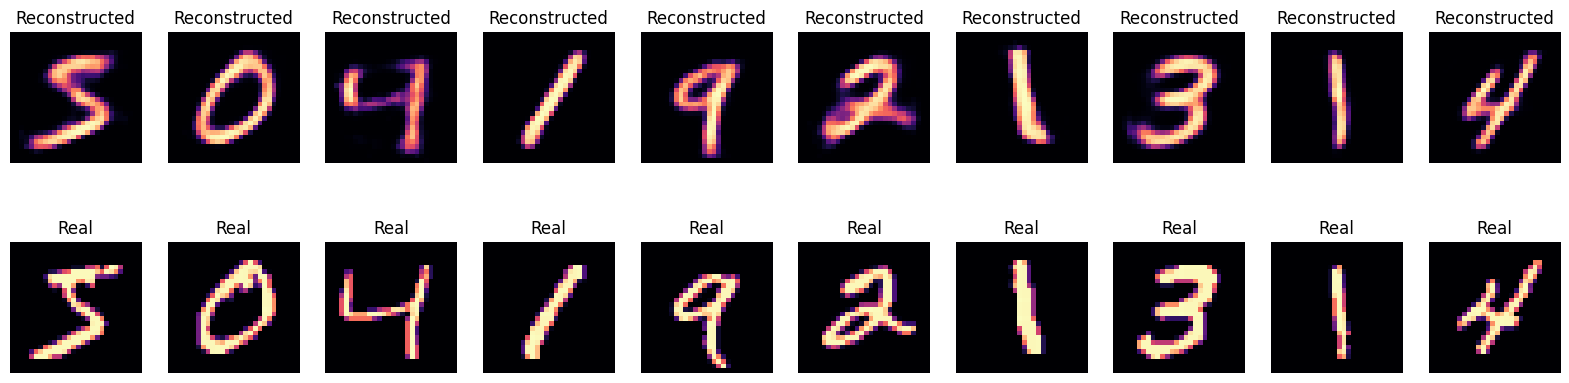

In [11]:
fig, axs = plt.subplots(2, 10, figsize = (20, 5))

gen_imgs = decoded.detach().cpu().numpy().transpose(0, 2, 3, 1)
real_imgs = batch_imgs.detach().cpu().numpy().transpose(0, 2, 3, 1)

for i, ax in enumerate(axs.flat):

    if i < 10:

        renormalized = gen_imgs[i]*0.5 + 0.5*np.ones_like(gen_imgs[i])
        ax.imshow(renormalized, cmap = plt.cm.magma)
        ax.axis("off")
        ax.set_title("Reconstructed")

    elif 10 <= i < 20:

        renormalized = real_imgs[i - 10]*0.5 + 0.5*np.ones_like(gen_imgs[i])
        ax.imshow(renormalized, cmap = plt.cm.magma)
        ax.axis("off")
        ax.set_title("Real")

plt.show()

In [12]:
zero = encoded[1]
one = encoded[3]
two = encoded[5]
three = encoded[7]
four = encoded[2]
four_2 = encoded[9]
five = encoded[0] 
six = encoded[13]
seven = encoded[29]
eight = encoded[17]
nine = encoded[4]


In [13]:
def decode_and_show(x):
    plt.imshow(decoder(x.unsqueeze(0)).data.numpy().transpose(0, 2, 3, 1).squeeze())
    plt.show()

In [14]:
def show_transition(x, y):

    fig, axs = plt.subplots(5, 10, figsize = (20, 10))

    line = np.linspace(0, 1, 50)

    for i, ax in enumerate(axs.flat):

        interm = x + line[i]*(y - x)

        out = decoder(interm.unsqueeze(0))
        img = out.data.numpy().transpose(0, 2, 3, 1).squeeze()

        ax.imshow(img, cmap = plt.cm.magma)
        ax.axis("off")

    plt.show()


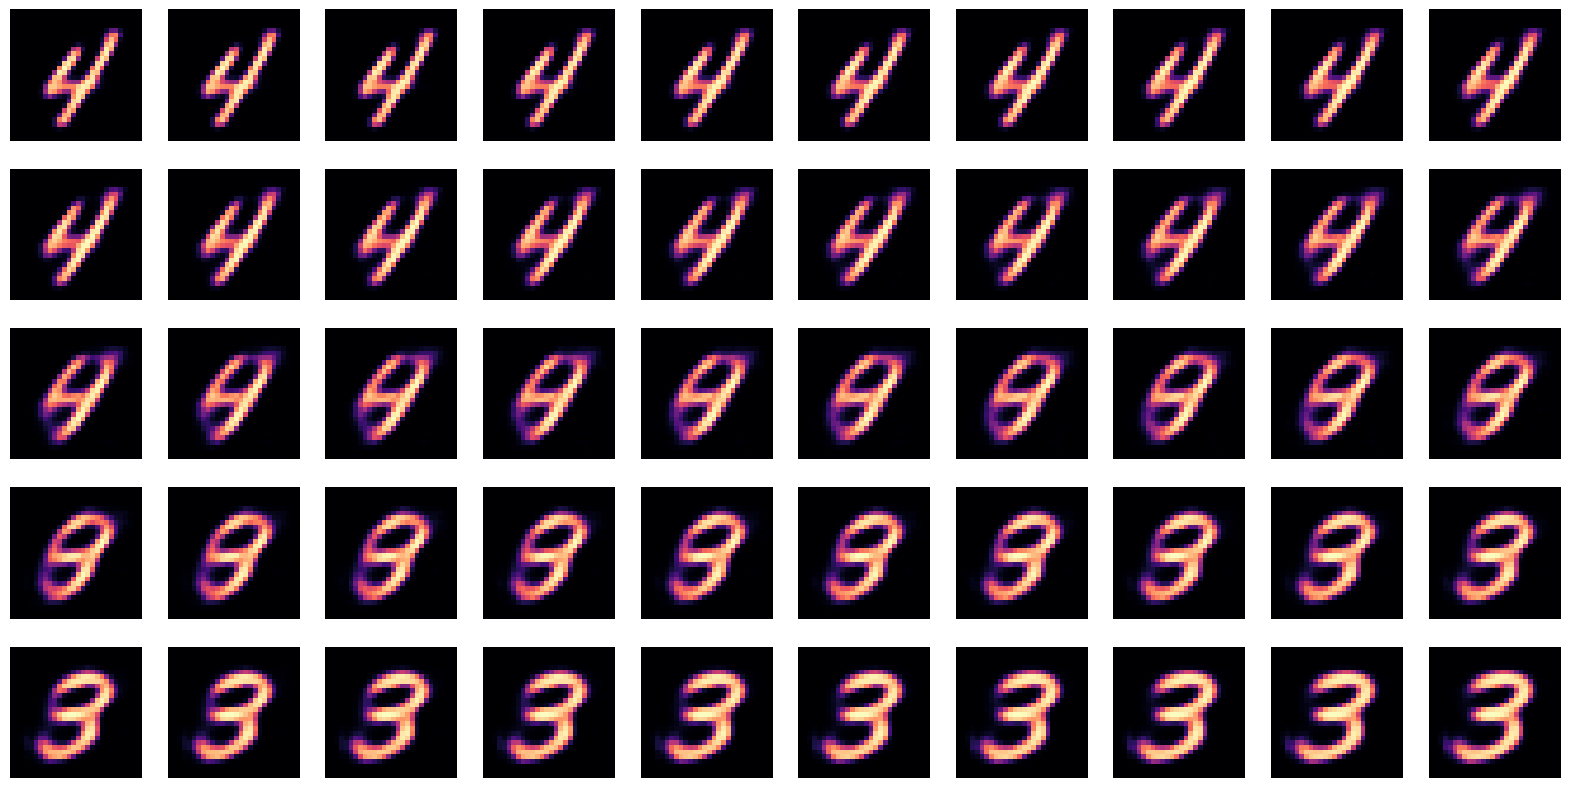

In [18]:
show_transition(four_2, three)

In [19]:
encodings = np.zeros((1, 20))
labels = np.zeros(1)


for batch_imgs, batch_lbls in loader:


    mu, sigma = encoder(batch_imgs)

    z = torch.randn(size = (mu.size(0),mu.size(1)))
    z= z.type_as(mu) 
    reparametrized = mu + sigma*z
    encoded = reparametrized.data.numpy()
    #encoded = encoder(batch_imgs).data.numpy()
    encodings = np.concatenate((encodings, encoded))
    labels = np.concatenate((labels, batch_lbls.numpy()))

encodings = encodings[1:, :]
labels = labels[1:]

In [20]:
latent_space = encodings

In [21]:
pca = PCA(n_components=2)

In [22]:
lower_lat_space = pca.fit_transform(latent_space)

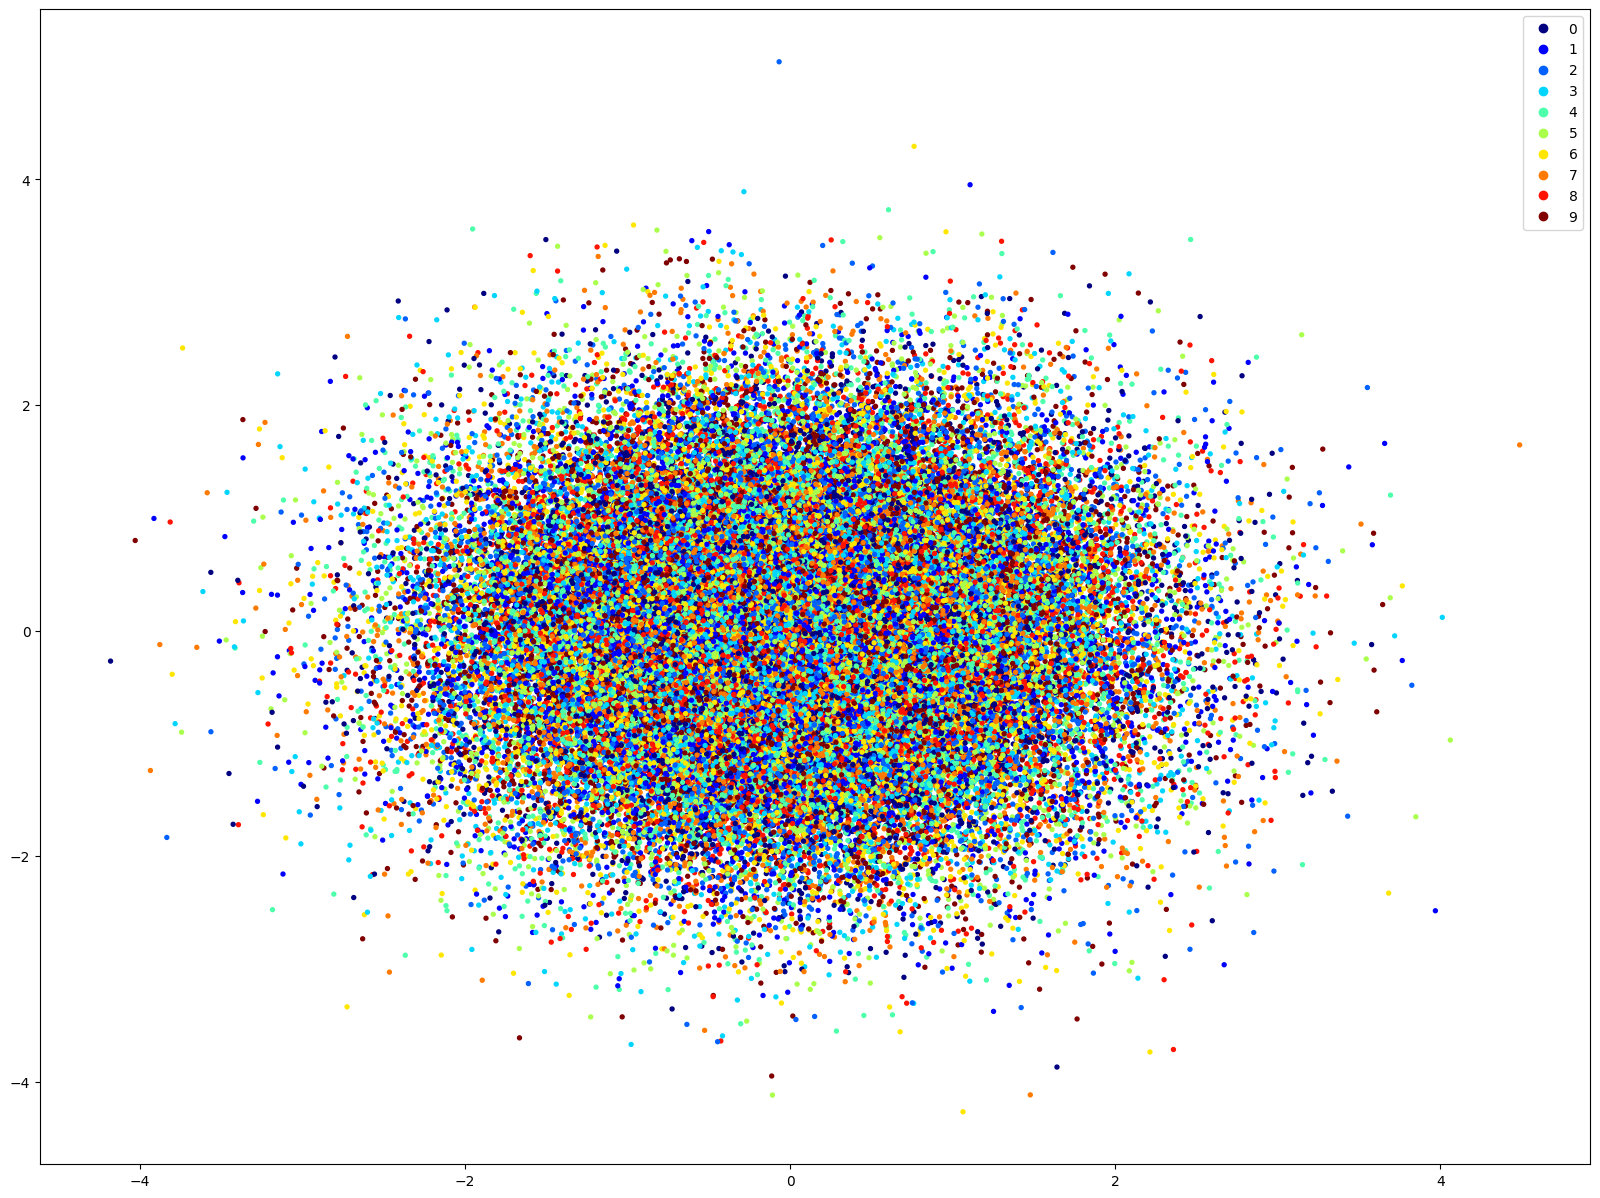

In [23]:
plt.figure(figsize = (20, 15))
scatter = plt.scatter(lower_lat_space[:, 0], lower_lat_space[:, 1], c = labels, s = 8, cmap = plt.cm.jet)
plt.legend(*scatter.legend_elements())
plt.show()

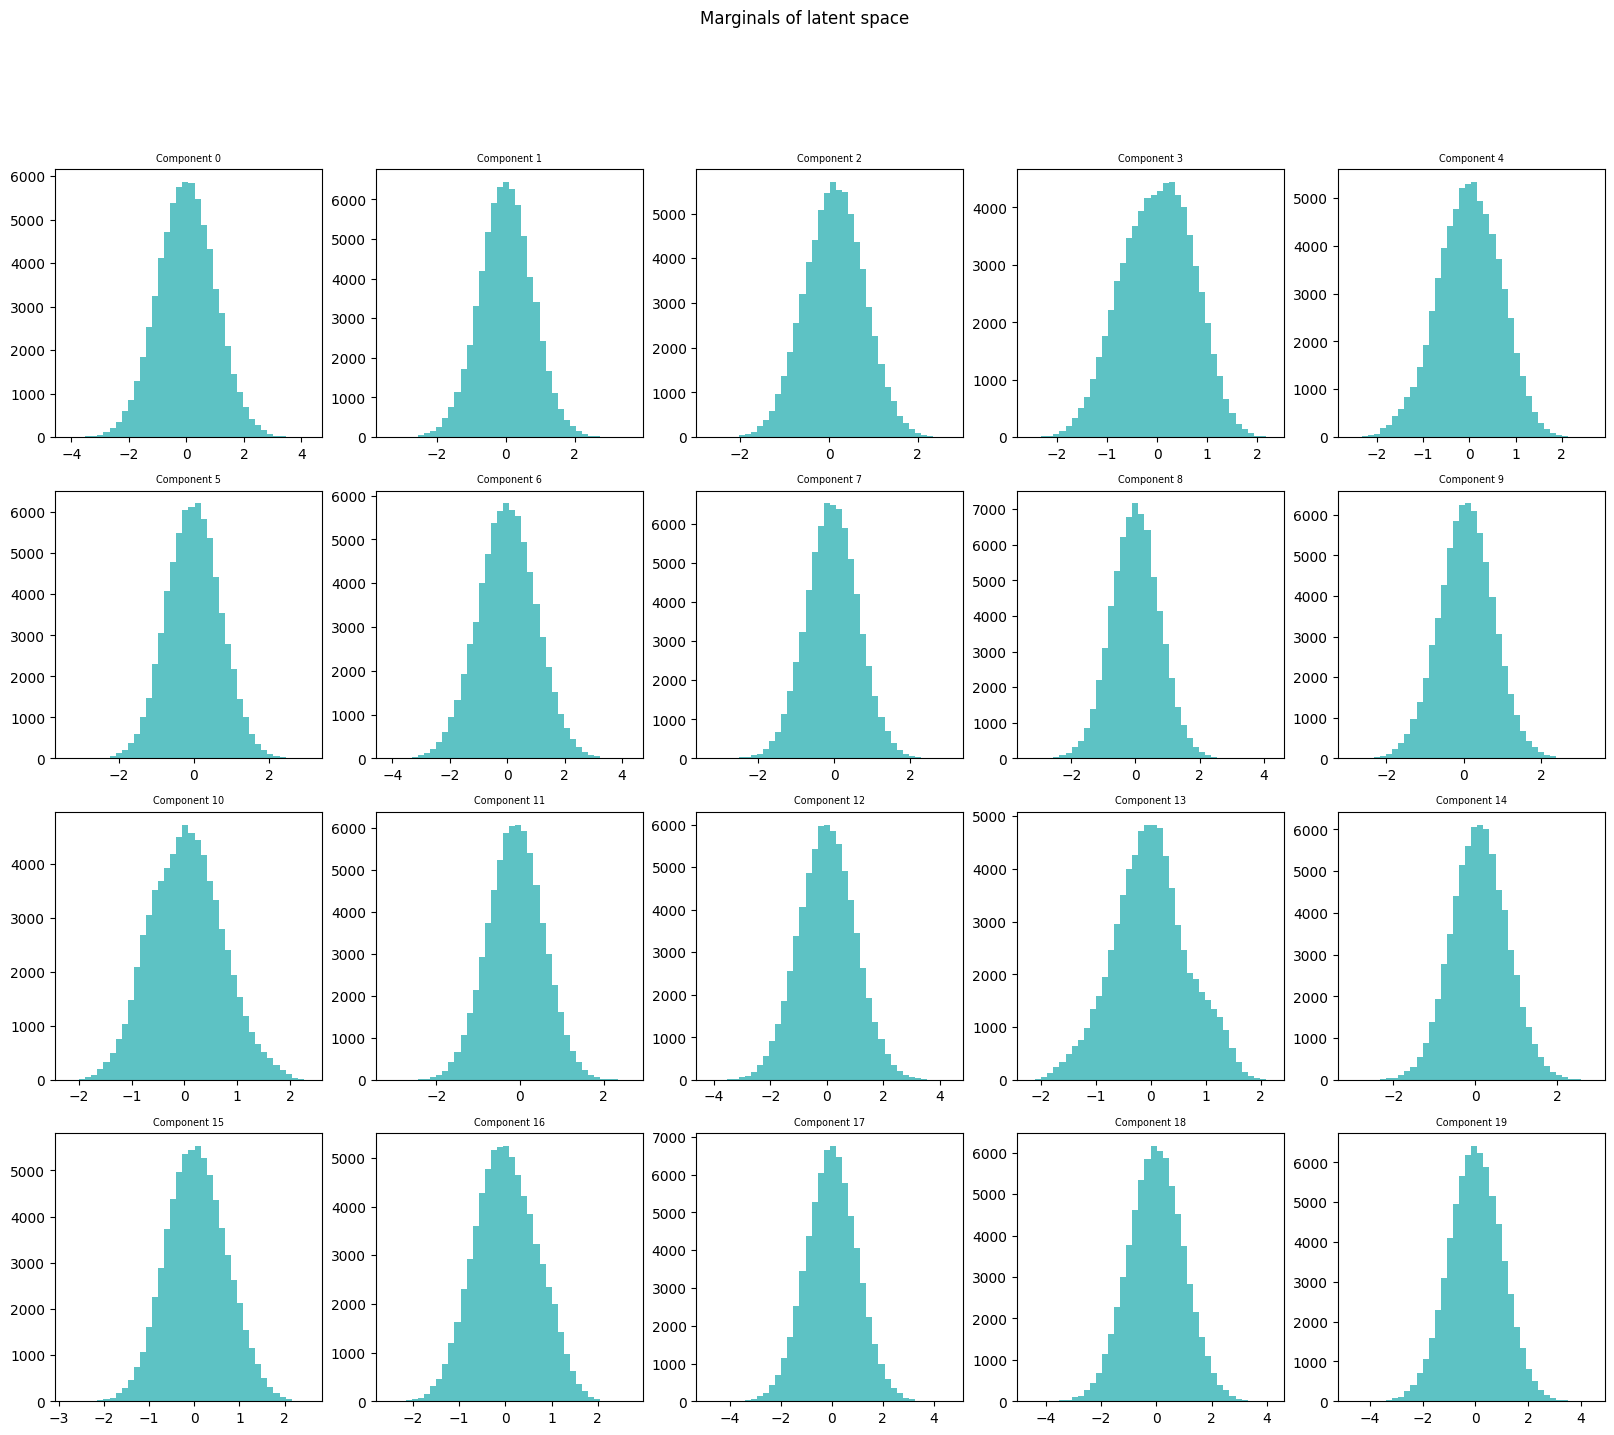

In [24]:
fig, axs = plt.subplots(4, 5, figsize = (20, 16))

spacing = np.linspace(0, 1, 20)

fig.suptitle("Marginals of latent space")

for i, ax in enumerate(axs.flat):
    ax.hist(encodings[:, i], alpha = .8, bins = 40, color = "#34B3B6")
    ax.set_title(f"Component {i}", size = "x-small")

plt.show()

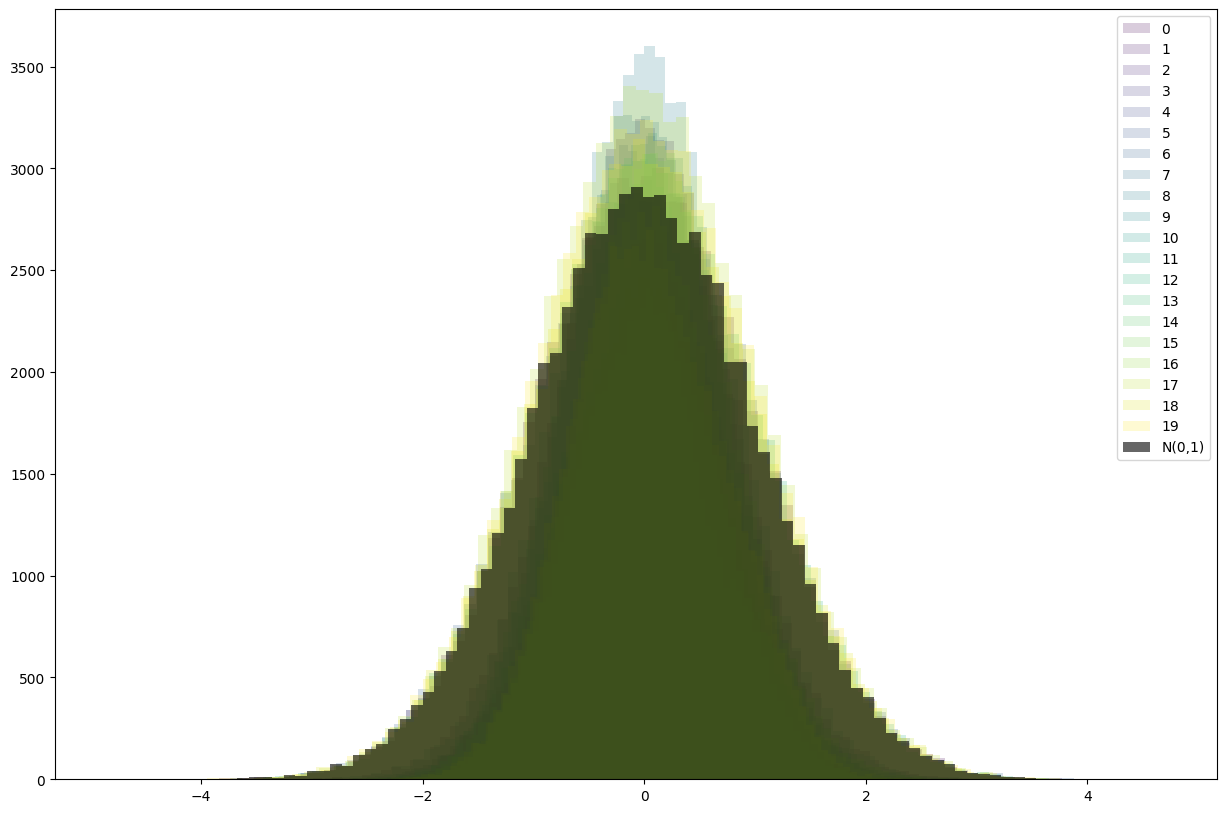

In [26]:
plt.figure(figsize = (15, 10))

spacing = np.linspace(0, 1, 20)

for i in range(20):

    plt.hist(encodings[:, i], alpha = .2, color = plt.cm.viridis(spacing[i]), bins = 80, label = i)

plt.hist(np.random.normal(0, 1, size = 70000), bins = 80, label = "N(0,1)", color = "black", alpha = .6)


plt.legend()
plt.show()

In [27]:
per_class_encodings = {k: encodings[np.where(labels == k)[0]] for k in range(10)}

In [ ]:
count = 0

for i in range(10):
    print(per_class_encodings[i].shape)
    count += per_class_encodings[i].shape[0]

print(count)

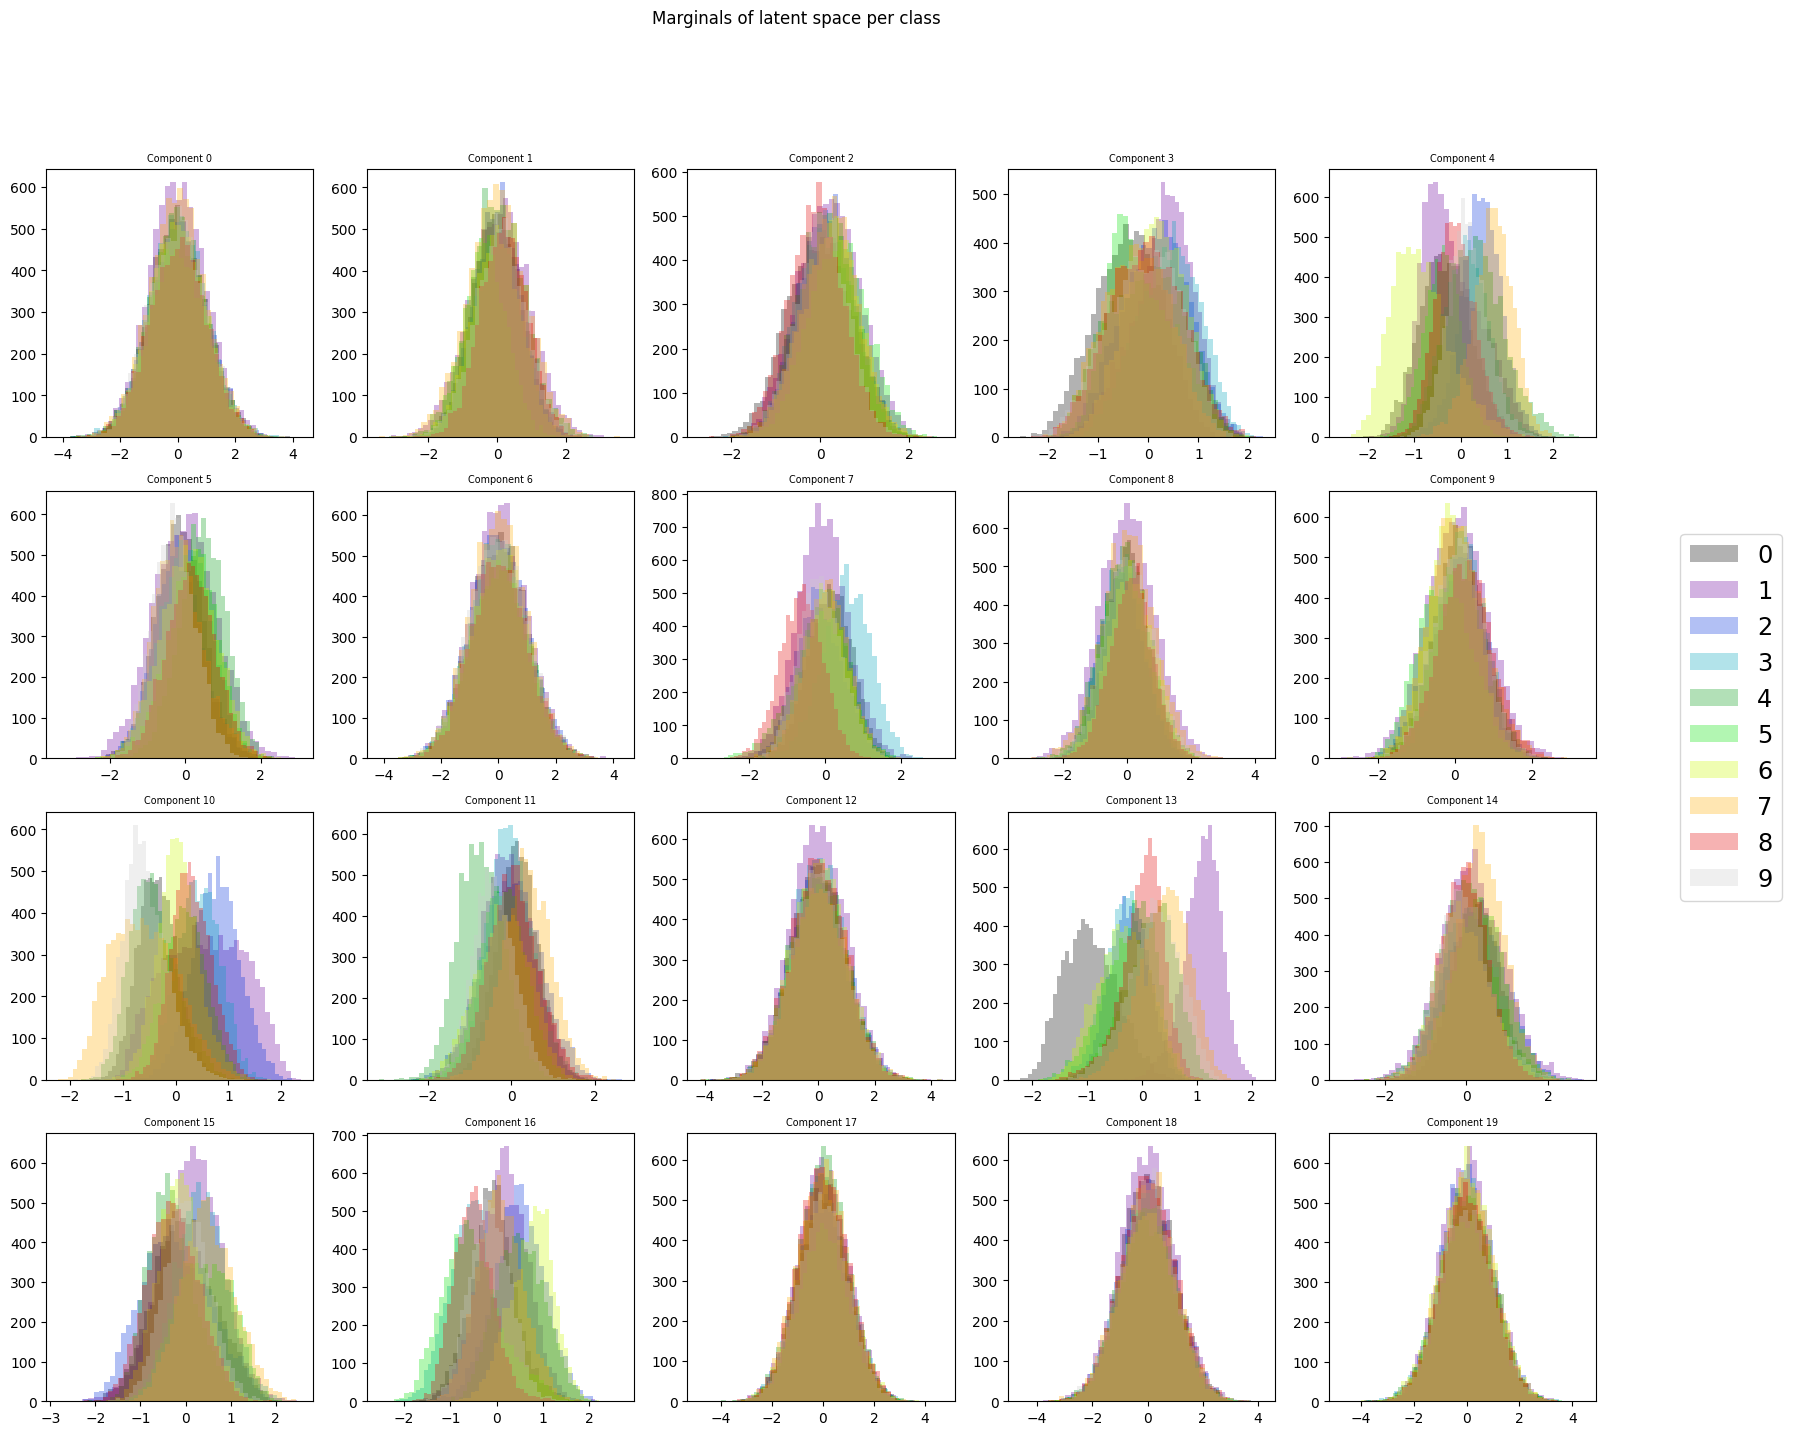

In [28]:
fig, axs = plt.subplots(4, 5, figsize = (20, 16))

spacing = np.linspace(0, 1, 10)

fig.suptitle("Marginals of latent space per class")

for i, ax in enumerate(axs.flat):

    for k, v in per_class_encodings.items():

        ax.hist(v[:, i], alpha = .3, bins = 40, label = k, color = plt.cm.nipy_spectral(spacing[k]))
    
    ax.set_title(f"Component {i}", size = "x-small")


handles, lbls = ax.get_legend_handles_labels()

fig.legend(handles, lbls, loc = "right", fontsize = "xx-large")

plt.show()

In [ ]:
plt.close()

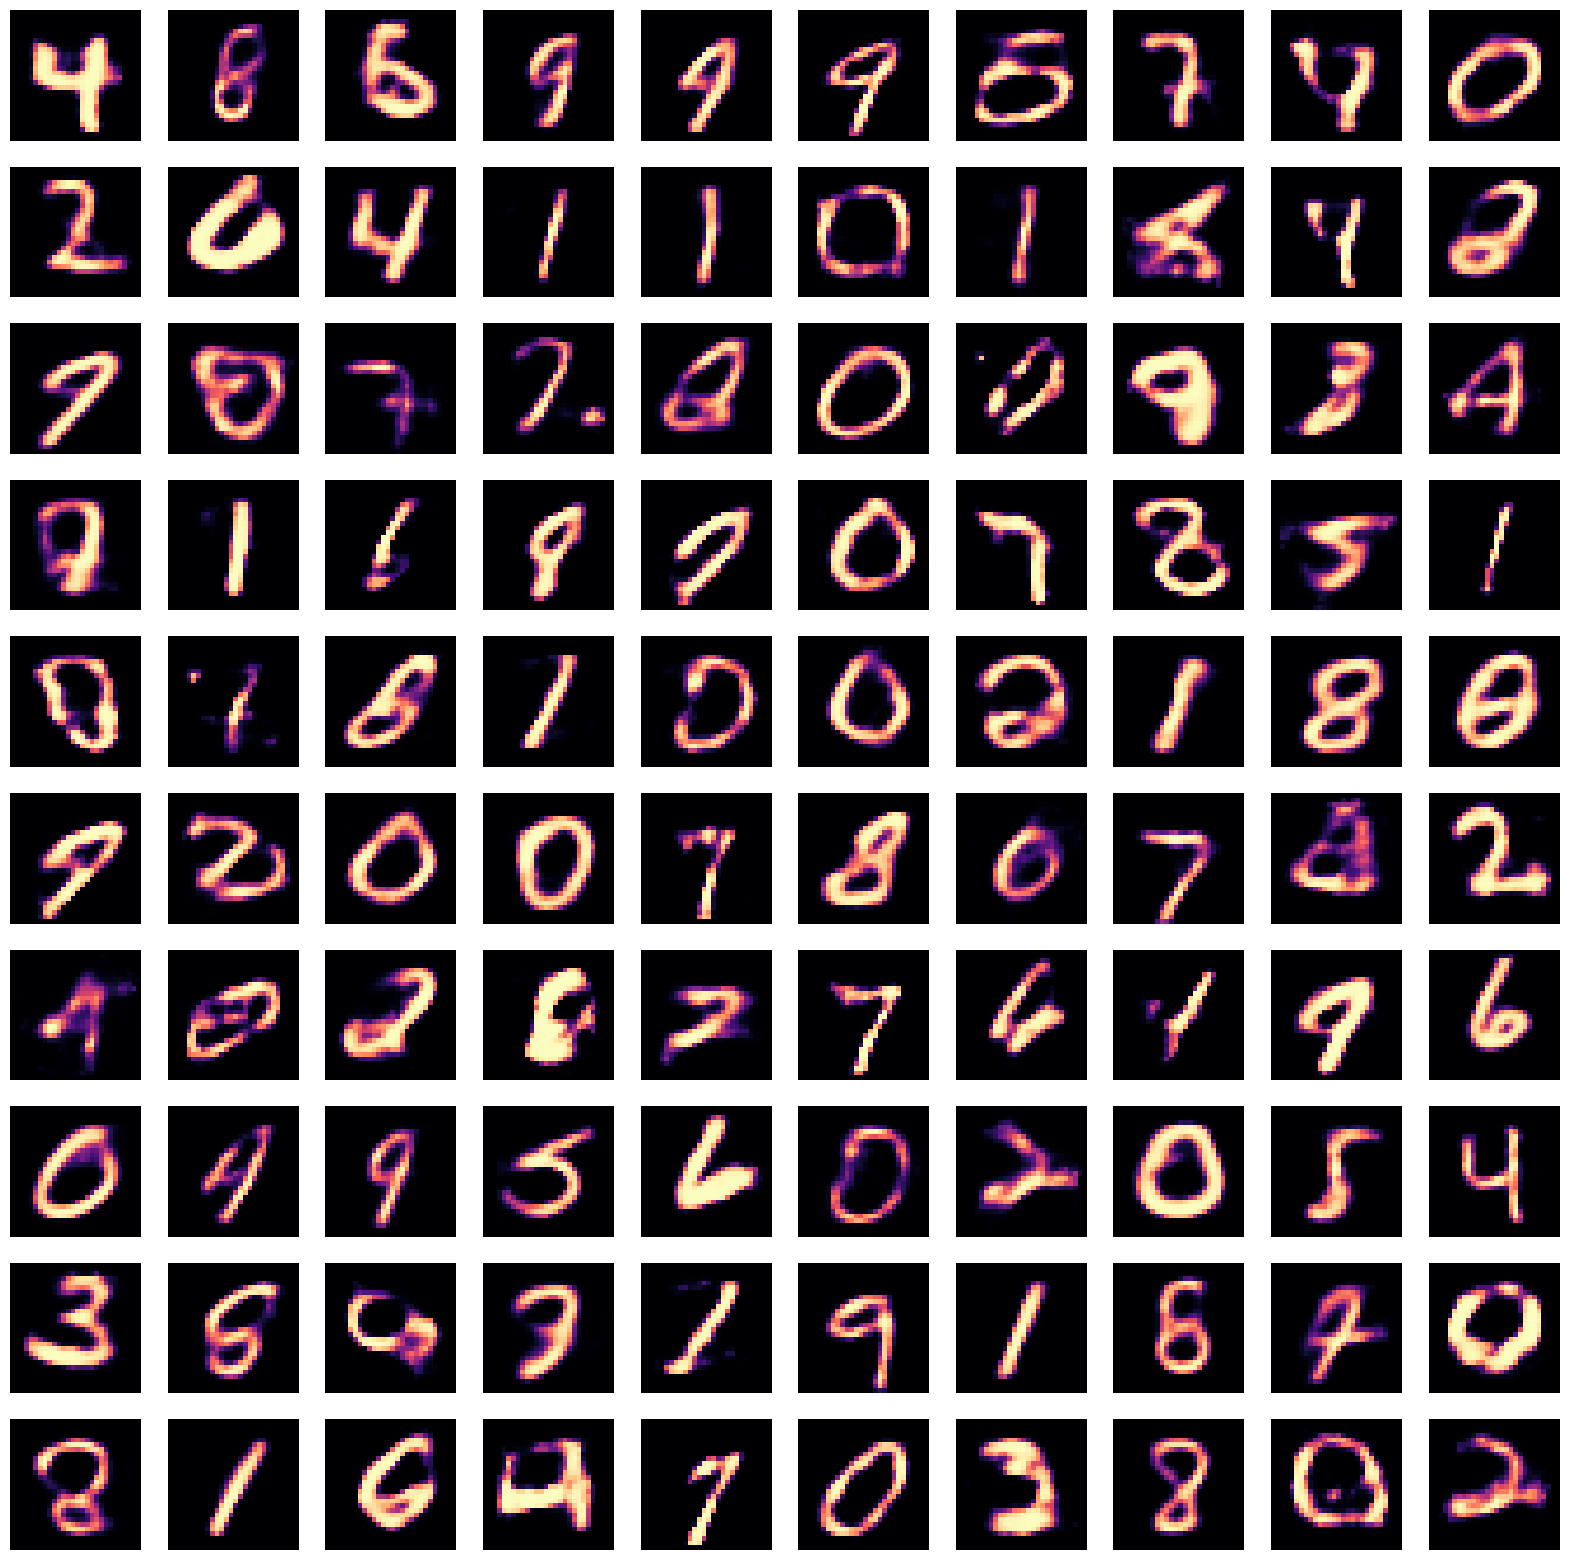

In [33]:
fig, axs = plt.subplots(10, 10, figsize = (20, 20))

gaussian_noise = torch.randn(100, 20)

gen_imgs = decoder(gaussian_noise).detach().cpu().numpy().transpose(0, 2, 3, 1)

for i, ax in enumerate(axs.flat):

    renormalized = gen_imgs[i]*0.5 + 0.5*np.ones_like(gen_imgs[i])
    ax.imshow(renormalized, cmap = plt.cm.magma)
    ax.axis("off")
    #ax.set_title(str(x[i]), size = "xx-small")

plt.show()